# Анализ результативности футбольных команд

Команда «Е.Д.А.»
 - Максимов Дмитрий Николаевич
 - Никитина Елизавета Андреевна
 - Соловьев Александр Сергеевич 

## Шаг 1. Тема и общее описание проекта

В футболе существует огромное количество статистики по итогам матчей — количество пасов/навесов, xG (Expected Goals), доля ударов в створ и многое другое. Наша команда заинтересовалась, можно ли по этой статистике оценивать результативность футбольной команды и, соответственно, пытаться предсказывать исход матчей.

Для этого мы решили взглянуть на последние несколько сезонов Английской Премьер лиги и поставили задачу предугадать чемпиона текущего сезона. В качестве основного источника данных мы взяли сайт https://fbref.com/en/, так как он предоставляет большое количество статистики

## Шаг 2. Сбор данных

### Как мы собирали данные?
Fbref имеет некоторые ограничения для сбора данных — слишком частые запросы (больше 20 в минуту) блокируются, поэтому в одной из версий парсера мы решили расставить паузы так, чтобы не нарушать это требование со стороны fbref. В итоге необходимые данные мы скачали за примерно 1.5 часа. 
Код парсера можно посмотреть [здесь](https://github.com/asolovyov03/soccer-analysis/blob/main/scripts/parse.py)

Итоговые данные мы сохранили в файл [match_stats.json](https://github.com/asolovyov03/soccer-analysis/blob/main/match_stats.json)

### Какие данные мы собрали?
Мы решили взять статистику всех матчей АПЛ с сезона 2018-2019 по текущий (последний матч на момент парсинга прошёл 8 мая)
Для домашней и гостевой команды мы собрали следующие признаки:
- **team**: название команды
- **score**: количество голов, которая команда забила по итогам матча
- **xG**: показатель Expected Goals (расчитана аналитической компанией Opta)
- **possession**: доля владения мячом
- **passing_accuracy**: точность пасов (доля успешных пасов)
- **shots_on_target**: доля ударов в створ
- **yellow_cards_count**: количество желтых карточек
- **red_cards_count**: количество красных карточек
- **fouls**: количество совершенных фолов
- **corners**: количество угловых
- **crosses**: количество навесов
- **touches**: количество касаний мяча
- **tackles**: количество перехватов
- **interceptions**: количество отборов мяча
- **aerials_won**: количество выигрышей мяча в воздухе
- **clearances**: количество выбитых мячей
- **offsides**: количетсво попаданий в оффсайд
- **goal_kicks**: количество ударов от ворот
- **throw_ins**: количество вбросов в игру
- **long_balls**: количество дальних передач
- **match_date**: дата матча
- **match_week**: номер недели чемпионата

## Шаг 3. Предварительная обработка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
with open("match_stats.json") as file:
    matches = json.loads(file.read())
stat_keys = matches[0]['home'].keys()
data = {}
data.update({'home_' + k: [] for k in stat_keys})
data.update({'guest_' + k: [] for k in stat_keys})

for match in matches:
    for key in match['home'].keys():
        data['home_' + key].append(match['home'][key])
    for key in match['guest'].keys():
        data['guest_' + key].append(match['guest'][key])

df = pd.DataFrame(data)

Взгляним на то, что из себя представляет полученный df

In [3]:
df.head()

home_team  home_score  home_xG  home_possession  \
0     Crystal Palace           0      1.2             0.56   
1             Fulham           2      1.2             0.33   
2  Tottenham Hotspur           4      1.5             0.58   
3   Newcastle United           2      1.7             0.61   
4       Leeds United           2      0.8             0.40   

   home_passing_accuracy  home_shots_on_target  home_yellow_cards_count  \
0                   0.84                  0.20                        1   
1                   0.60                  0.25                        2   
2                   0.83                  0.44                        3   
3                   0.79                  0.39                        0   
4                   0.74                  0.33                        2   

   home_red_cards_count  home_fouls  home_corners  ...  guest_crosses  \
0                     0          16             3  ...             11   
1                     0           7             4  ...             18   
2                     0          11            10  ...             18   
3                     0           9            11  ...              9   
4                     0          13             6  ...             20   

   guest_touches  guest_tackles  guest_interceptions  guest_aerials_won  \
0            599             29                    9                 14   
1            784             11                   10                 13   
2            554             14                   13                 11   
3            475             15                   10                 16   
4            720             16                   14                  7   

   guest_clearances  guest_offsides  guest_goal_kicks  guest_throw_ins  \
0                24               2                 2               14   
1                16               4                 5               35   
2                21               0                 4               14   
3                37               0                12               26   
4                17               1                 9               23   

   guest_long_balls  
0                59  
1                94  
2                61  
3                70  
4                72  

[5 rows x 40 columns]

Посчитаем основные статистики для наших признаков

In [4]:
df.describe()

home_score      home_xG  home_possession  home_passing_accuracy  \
count  1834.000000  1834.000000      1834.000000            1834.000000   
mean      1.504907     1.459597         0.509553               0.770365   
std       1.324670     0.822911         0.126357               0.074203   
min       0.000000     0.000000         0.180000               0.490000   
25%       1.000000     0.800000         0.420000               0.720000   
50%       1.000000     1.400000         0.510000               0.780000   
75%       2.000000     2.000000         0.610000               0.830000   
max       9.000000     5.900000         0.820000               0.920000   

       home_shots_on_target  home_yellow_cards_count  home_red_cards_count  \
count           1834.000000              1834.000000           1834.000000   
mean               0.332770                 1.607961              0.034351   
std                0.154987                 1.244984              0.190952   
min                0.000000                 0.000000              0.000000   
25%                0.230000                 1.000000              0.000000   
50%                0.330000                 1.000000              0.000000   
75%                0.430000                 2.000000              0.000000   
max                1.000000                 7.000000              2.000000   

        home_fouls  home_corners  home_crosses  ...  guest_crosses  \
count  1834.000000   1834.000000   1834.000000  ...     1834.00000   
mean     10.491821      5.648310     19.647764  ...       16.40458   
std       3.407925      3.062734      8.356045  ...        7.49540   
min       0.000000      0.000000      2.000000  ...        0.00000   
25%       8.000000      3.000000     13.000000  ...       11.00000   
50%      10.000000      5.000000     19.000000  ...       16.00000   
75%      13.000000      8.000000     25.000000  ...       21.00000   
max      23.000000     17.000000     62.000000  ...       53.00000   

       guest_touches  guest_tackles  guest_interceptions  guest_aerials_won  \
count    1834.000000    1834.000000          1834.000000        1834.000000   
mean      606.242094      16.541439            10.338059          16.693566   
std       133.001931       5.227156             4.130337           6.994573   
min       299.000000       3.000000             0.000000           1.000000   
25%       502.000000      13.000000             7.000000          12.000000   
50%       596.000000      16.000000            10.000000          16.000000   
75%       696.750000      20.000000            13.000000          21.000000   
max      1063.000000      46.000000            29.000000          52.000000   

       guest_clearances  guest_offsides  guest_goal_kicks  guest_throw_ins  \
count       1834.000000      1834.00000       1834.000000      1834.000000   
mean          22.523991         1.71265          7.833697        20.131407   
std           10.120319         1.48929          3.465855         6.070747   
min            1.000000         0.00000          0.000000         3.000000   
25%           15.000000         1.00000          5.000000        16.000000   
50%           21.000000         1.00000          8.000000        20.000000   
75%           28.000000         3.00000         10.000000        24.000000   
max           80.000000        10.00000         23.000000        44.000000   

       guest_long_balls  
count       1834.000000  
mean          68.393130  
std           13.462878  
min           30.000000  
25%           59.000000  
50%           67.000000  
75%           78.000000  
max          127.000000  

[8 rows x 38 columns]

Проверим, есть ли пропуски в данных

In [5]:
df.isna().any().any()

False

Пропуски отсутствуют

## Шаг 4. Визуализация

Попробуем посмотреть, есть ли некоторые ожидаемые закономерности в наших данных, с помощью визуализации

Сравним количество забитых голов дома и в гостях (принято считать, что в гостях играть сложнее)

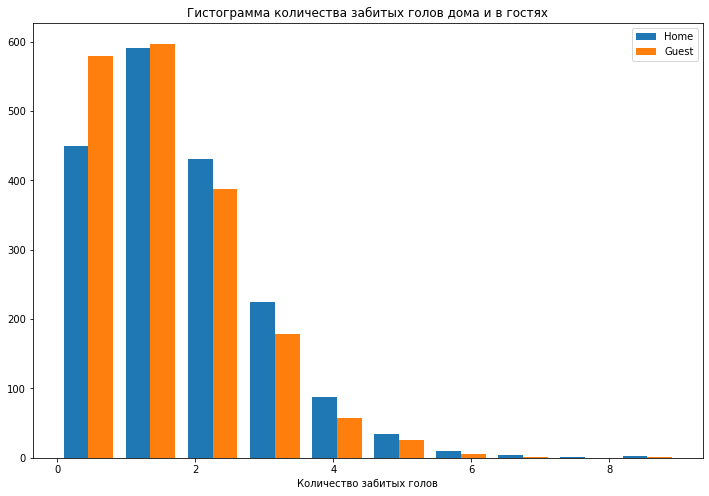

In [6]:
plt.figure(figsize=(12,8))
plt.hist([df['home_score'], df['guest_score']], label=['Home', 'Guest'])
plt.title("Гистограмма количества забитых голов дома и в гостях")
plt.xlabel("Количество забитых голов")
plt.legend();

Заметно, что у распределения голов гостей более тяжелый левый хвост. Они чаще не забивают вовсе или ограничиваются одним голом, хозяева же чаще результативнее. Можно предположить, что это связано со тактикой команды — в гостях больше защищаемся и менее активно атакуем. Давайте попробуем это проверить

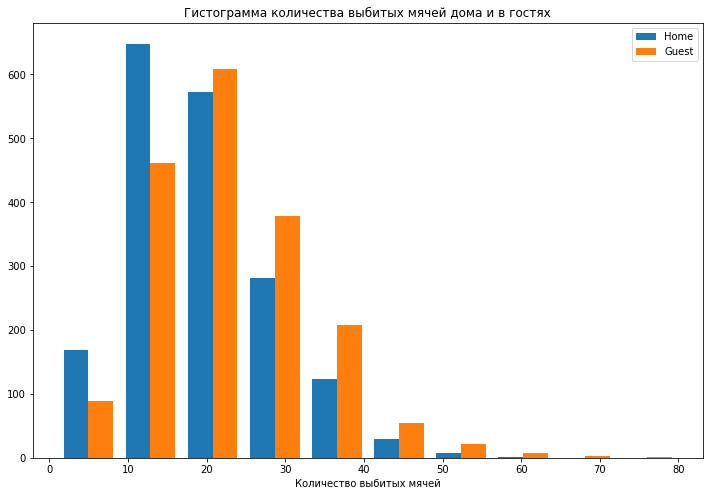

In [7]:
plt.figure(figsize=(12,8))
plt.hist([df['home_clearances'], df['guest_clearances']], label = ['Home', 'Guest'])
plt.title("Гистограмма количества выбитых мячей дома и в гостях")
plt.xlabel("Количество выбитых мячей")
plt.legend();

Видно, что гости заметно чаще выбивают мяч, посмотрим другие показатели игры от защиты

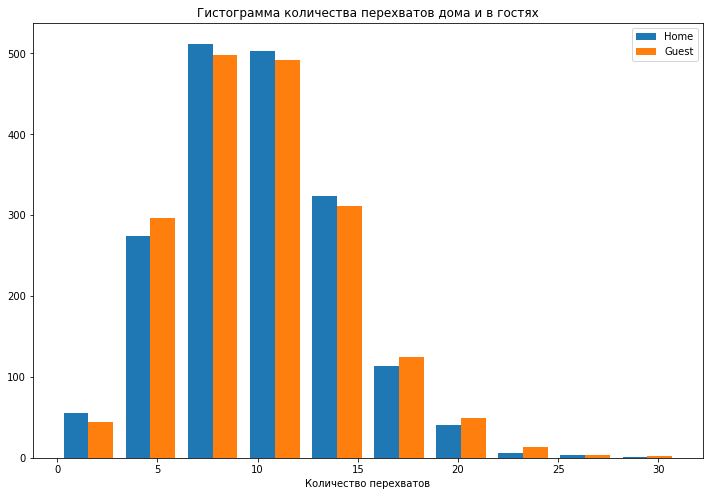

In [8]:
plt.figure(figsize=(12, 8))
plt.hist([df['home_interceptions'], df['guest_interceptions']], label=['Home', 'Guest'])
plt.title("Гистограмма количества перехватов дома и в гостях")
plt.xlabel("Количество перехватов")
plt.legend();

А в количестве отборов различий нет. Интересно! Давайте посмотрим на корреляцию между показателями, связанными с игрой в защите и возможно найдем что-то интересное

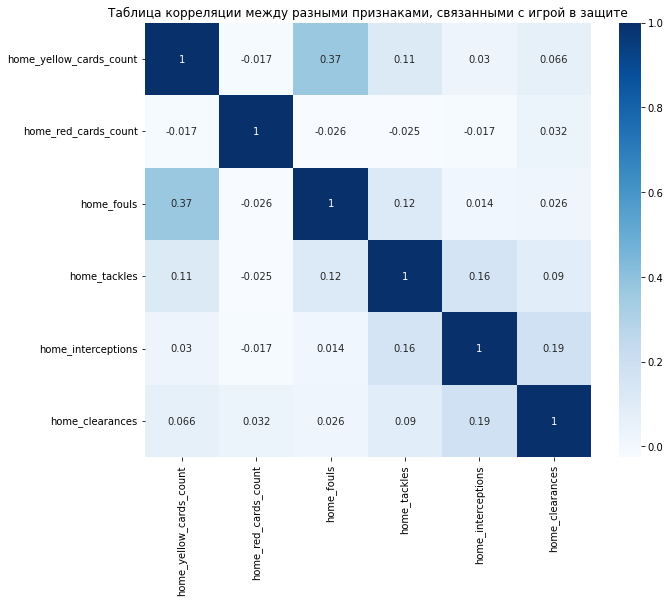

In [9]:
defensive_parametrs = ['home_yellow_cards_count', 'home_red_cards_count', 'home_fouls', 'home_tackles', 'home_interceptions', 'home_clearances']
plt.figure(figsize=(10, 8))
plt.title("Таблица корреляции между разными признаками, связанными с игрой в защите")
sns.heatmap(data=df[defensive_parametrs].corr(), annot=True, cmap='Blues');

Как заметно, почти везде корреляция достаточно слабая (кроме желтых карточек и фолов, что довольно очевидно). Об отсутствии зависимости говорить рано (вполне возможно она нелинейная), но это точно вопрос для дальнейшего изучения

Возможно низкая корреляция связана с тем, что каждый из этих показателей по-разному говорят об эффективности игры в защите. Например, перехват мяча позволяет дальше развить атаку, а выбивание его скорее говорит о неэффективности команды. Давайте сравним несколько показателей с количеством пропущенных и забитых голов

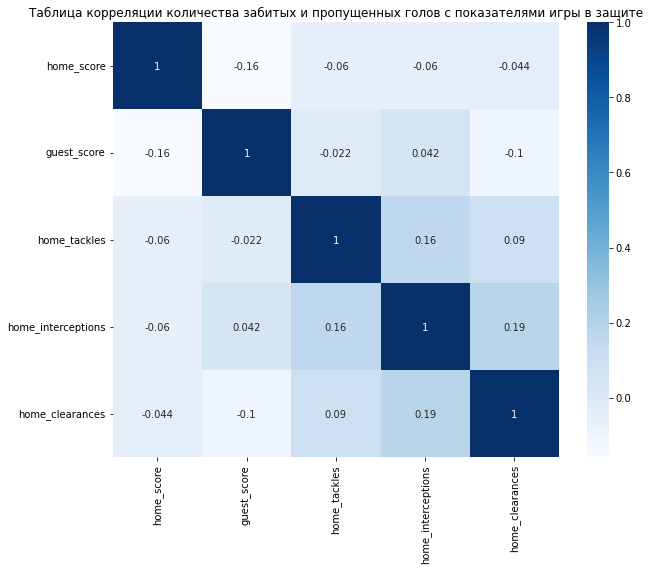

In [10]:
params = ['home_score', 'guest_score', 'home_tackles', 'home_interceptions', 'home_clearances']
plt.figure(figsize=(10, 8))
plt.title("Таблица корреляции количества забитых и пропущенных голов с показателями игры в защите")
sns.heatmap(data=df[params].corr(), annot=True, cmap='Blues');

Пока зависимостей в вопросах защиты особо не видно, оставим их поиск на более поздний этап

Посмотрим лучше на показатели атаки

Создадим df с основными показателями и количеством голов домашней команды и взгляним на него

In [11]:
df_home_score=df[['home_score','home_goal_kicks','home_passing_accuracy','home_possession']]
df_home_score.head()

home_score  home_goal_kicks  home_passing_accuracy  home_possession
0           0                4                   0.84             0.56
1           2                8                   0.60             0.33
2           4                5                   0.83             0.58
3           2                2                   0.79             0.61
4           2                9                   0.74             0.40

Попробуем найти закономерности. Для этого построим pairplot

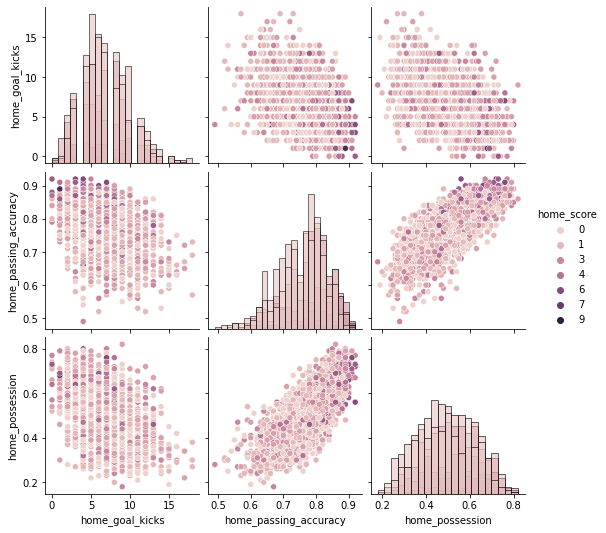

In [12]:
sns.pairplot(df_home_score,hue='home_score',diag_kind="hist");

Видна заметная зависимость между точностью пасов и владением мяча. Также заметно, что большое количество голов забивают команды с высоким значением владения мяча 

Посмотрим, есть ли отличия в данных зависимостях у гостевой команды

In [13]:
df_guest_score=df[['guest_score','guest_goal_kicks','guest_passing_accuracy','guest_possession']]
df_guest_score.head()

guest_score  guest_goal_kicks  guest_passing_accuracy  guest_possession
0            2                 2                    0.81              0.44
1            2                 5                    0.76              0.67
2            1                 4                    0.79              0.42
3            0                12                    0.71              0.39
4            1                 9                    0.84              0.60

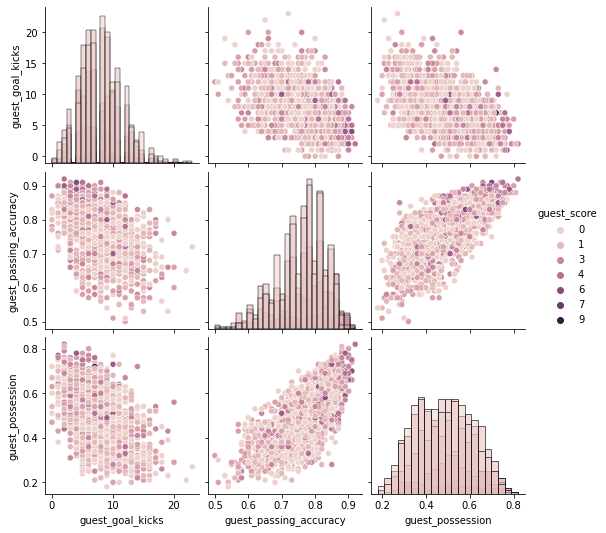

In [14]:
sns.pairplot(df_guest_score,hue='guest_score',diag_kind="hist");

Больших отличий не заметно

Теперь попробуем найти закономерности с ростом игроков. Для этого мы спарсили данные ([код парсера](https://github.com/asolovyov03/soccer-analysis/blob/main/scripts/Players_parser.py)) с сайта АПЛ и посчитаем средний рост для команд-участников чемпионата. Данные собраны в файле [information.tsv](https://github.com/asolovyov03/soccer-analysis/blob/main/information.tsv)

In [15]:
columns = ['Команда','Игрок','Позиция','Рост']
df_players = pd.read_table('information.tsv',sep=',', header=None,names=columns,skiprows=1)
df_players=df_players.iloc [1: , :]
df_players.loc[(df_players['Команда'] =='AFC Bournemouth'), 'Команда'] ='Bournemouth'
df_players.loc[(df_players['Команда'] =='Brighton and Hove Albion'), 'Команда'] ='Brighton & Hove Albion'
df_players.head()

Команда          Игрок     Позиция   Рост
1  Manchester United   David de Gea  Goalkeeper  192cm
2  Manchester United     Tom Heaton  Goalkeeper  188cm
3  Manchester United     Tom Heaton  Goalkeeper  188cm
4  Manchester United  Nathan Bishop  Goalkeeper  185cm
5  Manchester United   Jack Butland  Goalkeeper  196cm

In [16]:
df_players["Рост"] = df_players["Рост"].str.replace(r"[^\d\.]", "", regex=True)
df_players["Рост"] = df_players["Рост"].astype (int)
df_players['Рост_м'] = (df_players['Рост'])/100
df_players.head()

Команда          Игрок     Позиция  Рост  Рост_м
1  Manchester United   David de Gea  Goalkeeper   192    1.92
2  Manchester United     Tom Heaton  Goalkeeper   188    1.88
3  Manchester United     Tom Heaton  Goalkeeper   188    1.88
4  Manchester United  Nathan Bishop  Goalkeeper   185    1.85
5  Manchester United   Jack Butland  Goalkeeper   196    1.96

Добавим понижающий вес для вратаря — его высокий рост редко помогает команде забивать голы, так что не будем на нём сейчас сосредотачиваться

In [17]:
def assign_value(self):
    if str(self['Позиция']) =='Goalkeeper':
        return '0.5'
    else:
        return '1'

In [18]:
df_players['Веса'] = df_players.apply(assign_value, axis=1)
df_players.head()

Команда          Игрок     Позиция  Рост  Рост_м Веса
1  Manchester United   David de Gea  Goalkeeper   192    1.92  0.5
2  Manchester United     Tom Heaton  Goalkeeper   188    1.88  0.5
3  Manchester United     Tom Heaton  Goalkeeper   188    1.88  0.5
4  Manchester United  Nathan Bishop  Goalkeeper   185    1.85  0.5
5  Manchester United   Jack Butland  Goalkeeper   196    1.96  0.5

In [19]:
df_players["Веса"] = df_players["Веса"].astype (float) #добавляем веса, уменьшая вес для вратаря, чтобы далее проверить корреляцию с угловыми
mean_height = df_players.groupby('Команда').agg({'Рост': lambda x: np.average(x, weights=df_players.loc[x.index, 'Веса'])})
mean_height.head()

Рост
Команда                           
Arsenal                 179.838235
Aston Villa             182.056604
Bournemouth             181.691176
Brentford               180.967213
Brighton & Hove Albion  179.322034

In [20]:
teams=mean_height.index.tolist() # создаем лист с командами для группировки

In [21]:
data=[]
for team in teams:
    corners=0
    goals=0
    tries=0
    for i in range(len(df)):
        if df['home_team'][i]==team:
            corners+=df['home_corners'][i].astype(int)
            tries+=df['home_goal_kicks'][i].astype(int)
            goals+=df['home_score'][i].astype(int)
        if df['guest_team'][i]==team:
            corners+=df['guest_corners'][i].astype(int)
            tries+=df['guest_goal_kicks'][i].astype(int)
            goals+=df['guest_score'][i].astype(int)
    data.append({'Команда': team, 'Угловые': corners,'Удары по воротам':tries,'Забито':goals})
merged=pd.DataFrame(data)
merged=merged.set_index('Команда')
merged_df = pd.merge(merged, mean_height, on='Команда', how='outer')
merged_df.head()

Угловые  Удары по воротам  Забито        Рост
Команда                                                              
Arsenal                    1049              1182     327  179.838235
Aston Villa                 737              1104     192  182.056604
Bournemouth                 508               908     127  181.691176
Brentford                   299               529      96  180.967213
Brighton & Hove Albion      939              1250     210  179.322034

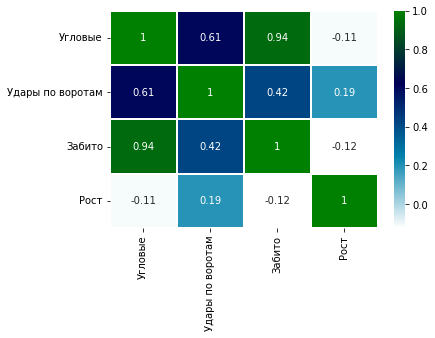

In [22]:
sns.heatmap(
    merged_df.corr(),
    annot=True,
    cmap='ocean_r',
    linewidths=0.1
);

Рост слабо коррелирует с другими показателями, зато видно интересные закономерности — количество угловых очень сильно коррелирует с количеством голов

Построим pairplot, чтобы визуально посмотреть, есть ли нелинейные зависимости 

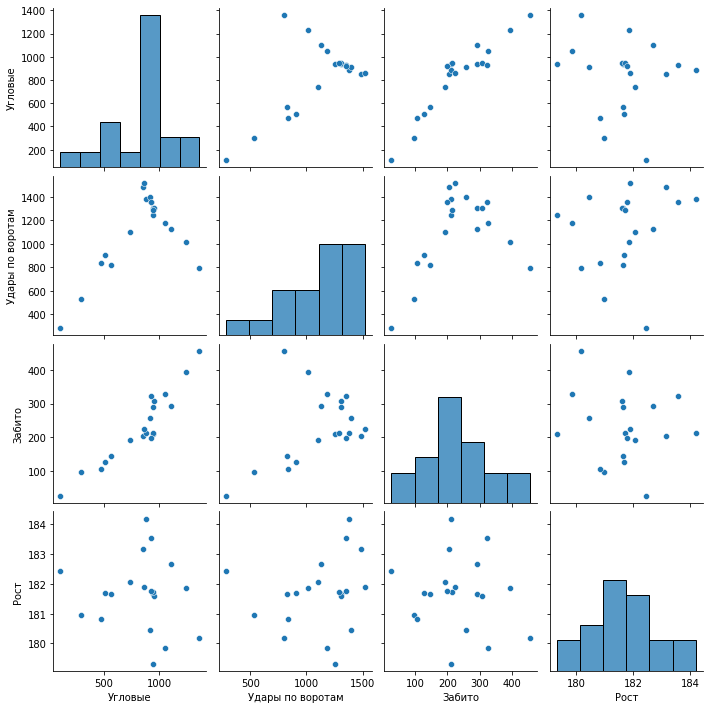

In [23]:
sns.pairplot(merged_df);

К сожалению, в наших данных нет показателя количества голов, забитых с углового, но попробуем воссоздать что-то похожее синтетически. Посчитаем отношение количества голов к угловым (с учётом того, что между ними есть сильная корреляция, можно это назвать эффективностью угловых, хотя это несколько спорно, потому что мы точно не знаем, что гол был забит с углового)

In [24]:
merged_df['Количество голов/Угловые']=merged_df['Забито']/merged_df['Угловые']
merged_df.head()

Угловые  Удары по воротам  Забито        Рост  \
Команда                                                                 
Arsenal                    1049              1182     327  179.838235   
Aston Villa                 737              1104     192  182.056604   
Bournemouth                 508               908     127  181.691176   
Brentford                   299               529      96  180.967213   
Brighton & Hove Albion      939              1250     210  179.322034   

                        Количество голов/Угловые  
Команда                                           
Arsenal                                 0.311725  
Aston Villa                             0.260516  
Bournemouth                             0.250000  
Brentford                               0.321070  
Brighton & Hove Albion                  0.223642

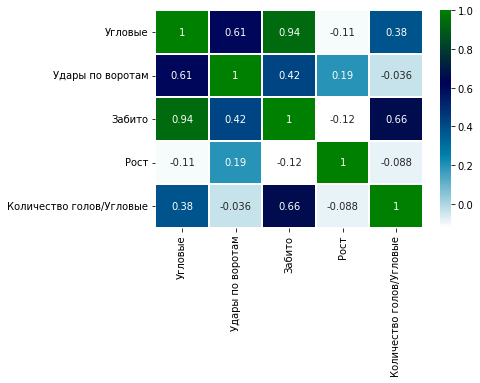

In [25]:
sns.heatmap(
    merged_df.corr(),
    annot=True,
    cmap='ocean_r',
    linewidths=0.1
);

Корреляции с ростом нет, это может как означать отсутствие зависимостей, так и просто то, что наш синтетический признак оказался плохим и мало информативным

Посмотрим на другие возможные зависимости

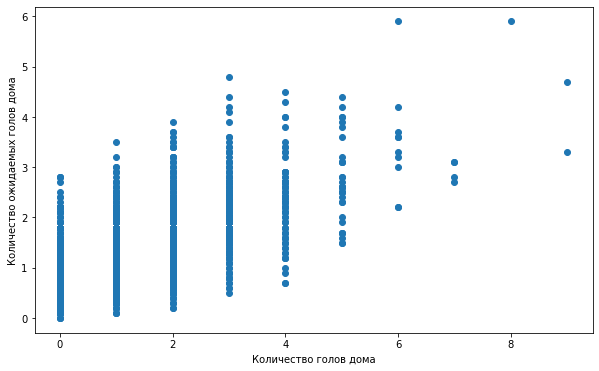

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df['home_score'], y = df['home_xG'])
plt.xlabel("Количество голов дома")
plt.ylabel("Количество ожидаемых голов дома")

plt.show()

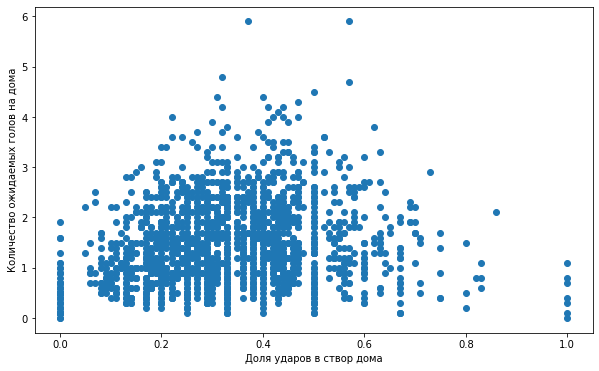

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df['home_shots_on_target'], y = df['home_xG'])
plt.xlabel("Доля ударов в створ дома")
plt.ylabel("Количество ожидаемых голов на дома")

plt.show()

Добавим df с признаками для домашней команды

In [28]:
df_3 = df[['home_team',
 'home_score',
 'home_xG',
 'home_possession',
 'home_passing_accuracy',
 'home_shots_on_target',
 'home_yellow_cards_count',
 'home_red_cards_count',
 'home_fouls',
 'home_corners',
 'home_crosses',
 'home_touches',
 'home_tackles',
 'home_interceptions',
 'home_aerials_won',
 'home_clearances',
 'home_offsides',
 'home_goal_kicks',
 'home_throw_ins',
 'home_long_balls']]
df_3

home_team  home_score  home_xG  home_possession  \
0        Crystal Palace           0      1.2             0.56   
1                Fulham           2      1.2             0.33   
2     Tottenham Hotspur           4      1.5             0.58   
3      Newcastle United           2      1.7             0.61   
4          Leeds United           2      0.8             0.40   
...                 ...         ...      ...              ...   
1829  Tottenham Hotspur           2      0.6             0.55   
1830          Liverpool           2      1.6             0.59   
1831  Manchester United           0      1.5             0.73   
1832             Fulham           0      0.7             0.67   
1833            Watford           1      2.2             0.49   

      home_passing_accuracy  home_shots_on_target  home_yellow_cards_count  \
0                      0.84                  0.20                        1   
1                      0.60                  0.25                        2   
2                      0.83                  0.44                        3   
3                      0.79                  0.39                        0   
4                      0.74                  0.33                        2   
...                     ...                   ...                      ...   
1829                   0.81                  0.27                        0   
1830                   0.82                  0.38                        0   
1831                   0.83                  0.38                        3   
1832                   0.88                  0.13                        1   
1833                   0.77                  0.47                        1   

      home_red_cards_count  home_fouls  home_corners  home_crosses  \
0                        0          16             3            19   
1                        0           7             4            19   
2                        0          11            10            24   
3                        0           9            11            25   
4                        0          13             6            20   
...                    ...         ...           ...           ...   
1829                     0          10             7            13   
1830                     0           3             4            18   
1831                     0           9            11            17   
1832                     0           6             5            28   
1833                     1          10             7            22   

      home_touches  home_tackles  home_interceptions  home_aerials_won  \
0              726            18                   8                10   
1              474            24                  10                23   
2              709            24                   3                13   
3              634            19                  11                12   
4              515            21                  14                 9   
...            ...           ...                 ...               ...   
1829           702            22                   9                17   
1830           752            16                   9                12   
1831           774            15                  15                19   
1832           901            12                  13                17   
1833           551            17                   4                12   

      home_clearances  home_offsides  home_goal_kicks  home_throw_ins  \
0                  18              1                4              25   
1                  31              4                8              22   
2                  20              2                5              20   
3                  14              2                2              21   
4                  23              0                9              16   
...               ...            ...              ...             ...   
1829               17              2                5  

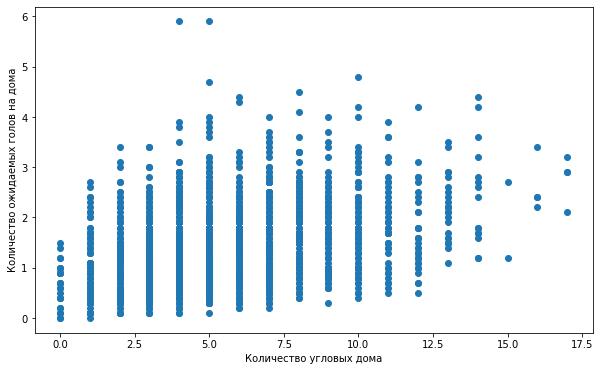

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df['home_corners'], y = df['home_xG'])
plt.xlabel("Количество угловых дома")
plt.ylabel("Количество ожидаемых голов на дома")

plt.show()

Видно, что угловые влияют и на xG (что логично, ведь xG считает не только самы голы, но и голевые моменты)

 Построим корреляционный heatmap

<ipython-input-31-9af4d1bdf992>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_c = df_3.corr(method='pearson')


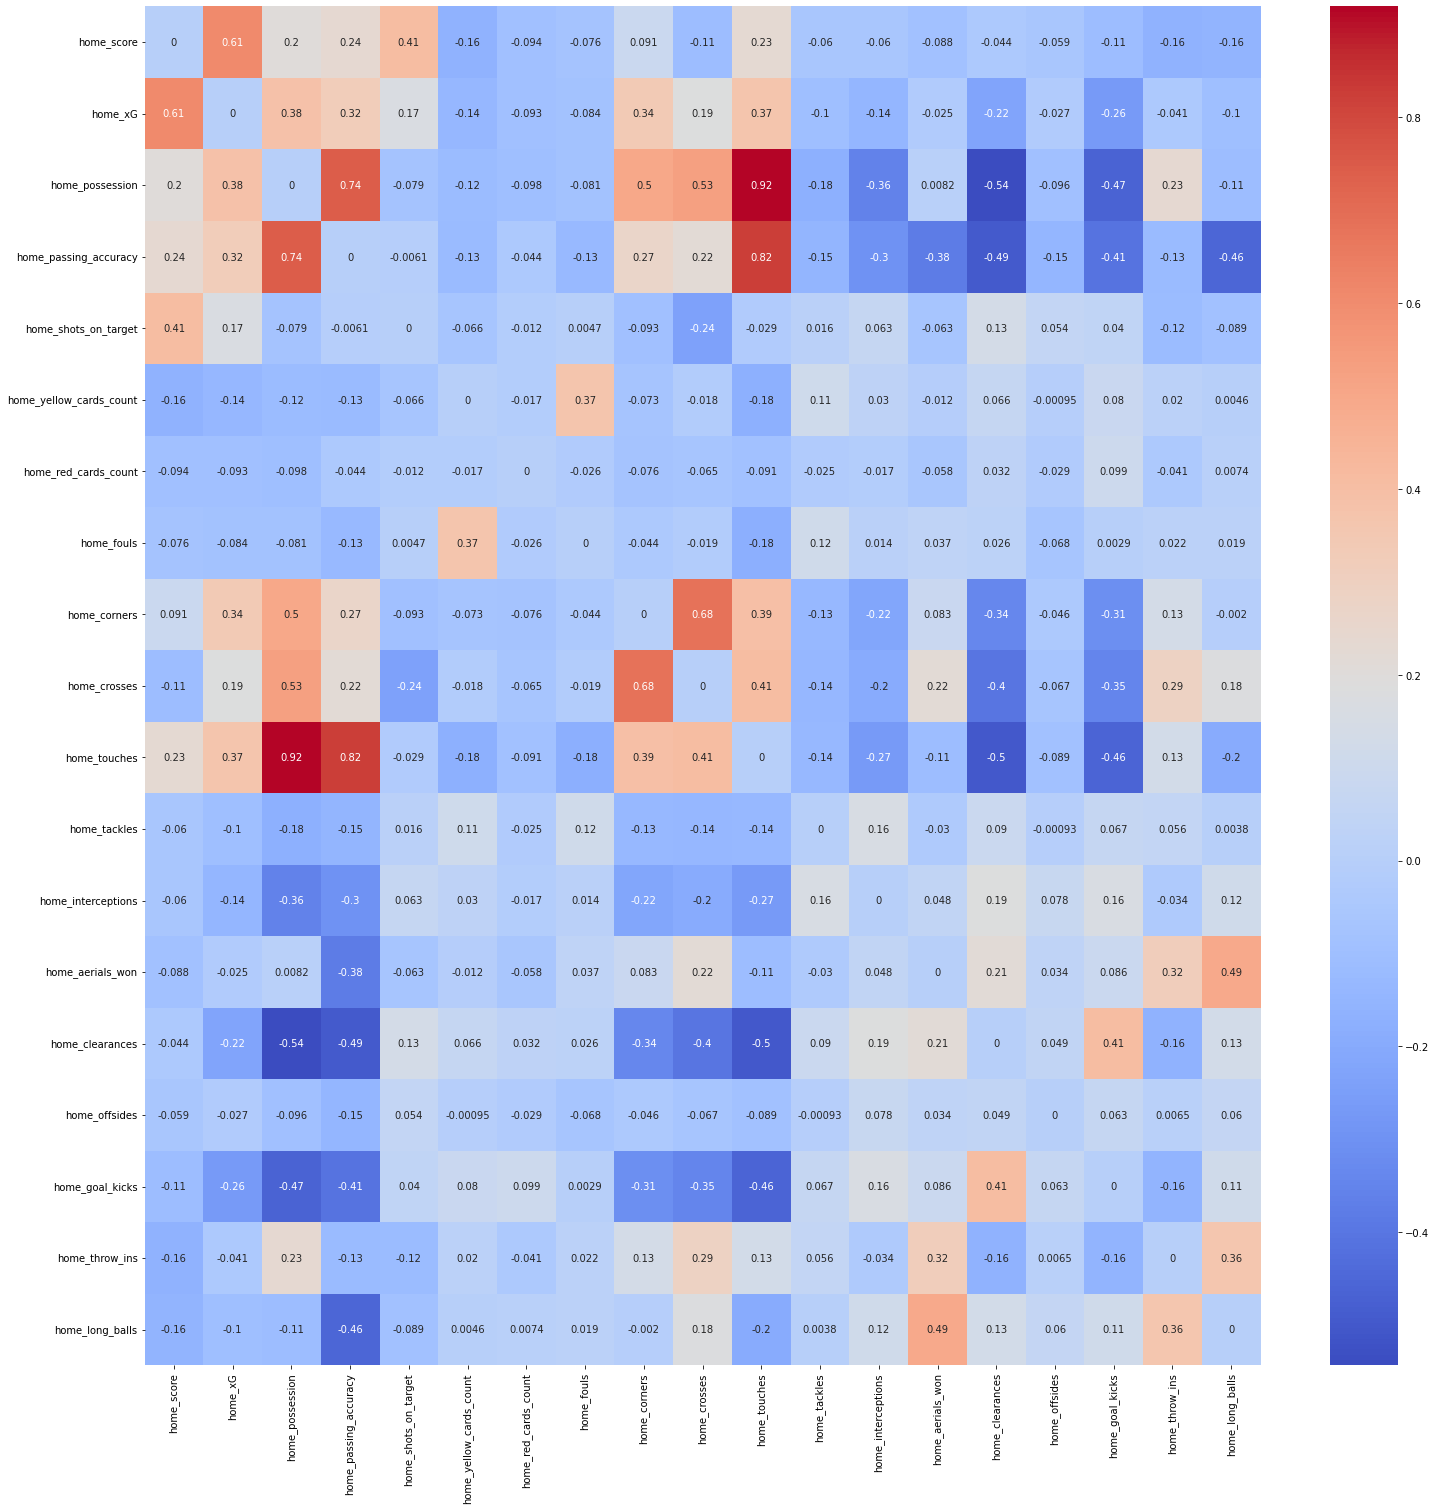

In [31]:
df_c = df_3.corr(method='pearson')
plt.figure(figsize = (25,25))
np.fill_diagonal(df_c.values, 0)
sns.heatmap(df_c, cmap='coolwarm', annot=True);

По тепловой карте выше видно, что из игровых действий команды дома лучше всего коррелирует количество касаний мяча и процент владения мячом, количество касаний и точность пасов, а также процент владения мячом и точность пасов

In [32]:
df_c.max().sort_values(ascending=False)

home_possession            0.919253
home_touches               0.919253
home_passing_accuracy      0.824886
home_crosses               0.681481
home_corners               0.681481
home_xG                    0.610529
home_score                 0.610529
home_aerials_won           0.492977
home_long_balls            0.492977
home_clearances            0.407577
home_goal_kicks            0.407577
home_shots_on_target       0.405406
home_fouls                 0.369113
home_yellow_cards_count    0.369113
home_throw_ins             0.363832
home_interceptions         0.185007
home_tackles               0.157232
home_red_cards_count       0.098522
home_offsides              0.078009
dtype: float64

Давайте посмотрим показатели Манчестер Сити, так как они сильнее выступали последние несколько сезонов

In [34]:
df_mc = df.loc[df['home_team'] == 'Manchester City']
df_mc.describe()

home_score    home_xG  home_possession  home_passing_accuracy  \
count   91.000000  91.000000        91.000000              91.000000   
mean     2.912088   2.340659         0.669670               0.876264   
std      1.729794   0.982285         0.081164               0.026818   
min      0.000000   0.500000         0.470000               0.800000   
25%      2.000000   1.600000         0.630000               0.860000   
50%      3.000000   2.200000         0.690000               0.880000   
75%      4.000000   2.950000         0.725000               0.890000   
max      8.000000   5.900000         0.800000               0.920000   

       home_shots_on_target  home_yellow_cards_count  home_red_cards_count  \
count             91.000000                91.000000             91.000000   
mean               0.355604                 1.098901              0.021978   
std                0.110566                 1.096002              0.147424   
min                0.060000                 0.000000              0.000000   
25%                0.270000                 0.000000              0.000000   
50%                0.350000                 1.000000              0.000000   
75%                0.420000                 2.000000              0.000000   
max                0.630000                 5.000000              1.000000   

       home_fouls  home_corners  home_crosses  ...  guest_crosses  \
count   91.000000     91.000000     91.000000  ...      91.000000   
mean     8.945055      8.098901     22.527473  ...       9.164835   
std      3.215803      3.577879     10.401219  ...       4.585639   
min      2.000000      1.000000      6.000000  ...       1.000000   
25%      6.500000      6.000000     15.500000  ...       6.000000   
50%      9.000000      8.000000     21.000000  ...       8.000000   
75%     11.000000     10.000000     28.000000  ...      11.500000   
max     19.000000     17.000000     62.000000  ...      21.000000   

       guest_touches  guest_tackles  guest_interceptions  guest_aerials_won  \
count      91.000000      91.000000            91.000000          91.000000   
mean      473.923077      15.384615            10.780220          10.956044   
std        96.485259       3.915125             3.788292           5.464862   
min       300.000000       6.000000             3.000000           2.000000   
25%       404.000000      13.000000             8.000000           7.500000   
50%       455.000000      15.000000            11.000000          10.000000   
75%       534.000000      18.000000            13.500000          14.000000   
max       782.000000      26.000000            20.000000          29.000000   

       guest_clearances  guest_offsides  guest_goal_kicks  guest_throw_ins  \
count         91.000000       91.000000         91.000000        91.000000   
mean          25.307692        1.956044         10.340659        13.285714   
std           11.242471        1.645952          4.126391         4.292851   
min            8.000000        0.000000          3.000000         3.000000   
25%           18.000000        1.000000          8.000000        10.000000   
50%           23.000000        2.000000          9.000000        13.000000   
75%           31.000000        3.000000         13.000000        15.000000   
max           80.000000       10.000000         23.000000        29.000000   

       guest_long_balls  
count         91.000000  
mean          60.703297  
std           10.925500  
min           36.000000  
25%           54.000000  
50%           61.000000  
75%           68.500000  
max           81.000000  

[8 rows x 38 columns]

Построим таблицу с основными показателями для всех команд чемпионата

In [35]:
df_gr = df_3.groupby(['home_team']).agg('mean')
df_gr

home_score   home_xG  home_possession  \
home_team                                                        
Arsenal                    1.978261  1.720652         0.575870   
Aston Villa                1.486111  1.380556         0.478889   
Bournemouth                1.240741  1.288889         0.442222   
Brentford                  1.485714  1.497143         0.438857   
Brighton & Hove Albion     1.166667  1.412222         0.529444   
Burnley                    1.052632  1.309211         0.431842   
Cardiff City               1.105263  1.289474         0.367895   
Chelsea                    1.673913  1.751087         0.608370   
Crystal Palace             1.032609  1.154348         0.463913   
Everton                    1.293478  1.322826         0.474022   
Fulham                     1.000000  1.185185         0.506481   
Huddersfield Town          0.526316  0.847368         0.491053   
Leeds United               1.277778  1.411111         0.539630   
Leicester City             1.586957  1.364130         0.536304   
Liverpool                  2.461538  2.149451         0.631758   
Manchester City            2.912088  2.340659         0.669670   
Manchester United          1.868132  1.707692         0.555275   
Newcastle United           1.373626  1.334066         0.430769   
Norwich City               0.794872  0.910256         0.456923   
Nottingham Forest          1.187500  1.162500         0.386250   
Sheffield United           0.947368  1.178947         0.448158   
Southampton                1.239130  1.205435         0.472065   
Tottenham Hotspur          1.913043  1.586957         0.537065   
Watford                    1.140351  1.264912         0.442632   
West Bromwich Albion       0.789474  0.973684         0.387895   
West Ham United            1.608696  1.368478         0.457717   
Wolverhampton Wanderers    1.206522  1.278261         0.502174   

                         home_passing_accuracy  home_shots_on_target  \
home_team                                                              
Arsenal                               0.816196              0.348913   
Aston Villa                           0.766250              0.350139   
Bournemouth                           0.736667              0.302963   
Brentford                             0.694857              0.339429   
Brighton & Hove Albion                0.784444              0.278111   
Burnley                               0.686842              0.311974   
Cardiff City                          0.603158              0.291579   
Chelsea                               0.841304              0.344022   
Crystal Palace                        0.747174              0.302826   
Everton                               0.743587              0.333804   
Fulham                                0.766481              0.283704   
Huddersfield Town                     0.725789              0.276842   
Leeds United                          0.769259              0.335741   
Leicester City                        0.793478              0.347283   
Liverpool                             0.827582              0.356264   
Manchester City                       0.876264              0.355604   
Manchester United                     0.811099              0.380330   
Newcastle United                      0.723077              0.310659   
Norwich City                          0.758974              0.328974   
Nottingham Forest                     0.691875              0.346875   
Sheffield United                      0.720000              0.315526   
Southampton                           0.730109              0.354348   
Tottenham Hotspur                     0.810543              0.367174   
Watford                               0.715263              0.300526   
West Bromwich Albion                  0.682105              0.366316   
West Ham United                       0.753696              0.348261   
Wolverhampton Wanderers               0.787609              0.315761   

                     

Отсортируем их по голам

In [36]:
df_gr.sort_values(by='home_score', ascending=False)

home_score   home_xG  home_possession  \
home_team                                                        
Manchester City            2.912088  2.340659         0.669670   
Liverpool                  2.461538  2.149451         0.631758   
Arsenal                    1.978261  1.720652         0.575870   
Tottenham Hotspur          1.913043  1.586957         0.537065   
Manchester United          1.868132  1.707692         0.555275   
Chelsea                    1.673913  1.751087         0.608370   
West Ham United            1.608696  1.368478         0.457717   
Leicester City             1.586957  1.364130         0.536304   
Aston Villa                1.486111  1.380556         0.478889   
Brentford                  1.485714  1.497143         0.438857   
Newcastle United           1.373626  1.334066         0.430769   
Everton                    1.293478  1.322826         0.474022   
Leeds United               1.277778  1.411111         0.539630   
Bournemouth                1.240741  1.288889         0.442222   
Southampton                1.239130  1.205435         0.472065   
Wolverhampton Wanderers    1.206522  1.278261         0.502174   
Nottingham Forest          1.187500  1.162500         0.386250   
Brighton & Hove Albion     1.166667  1.412222         0.529444   
Watford                    1.140351  1.264912         0.442632   
Cardiff City               1.105263  1.289474         0.367895   
Burnley                    1.052632  1.309211         0.431842   
Crystal Palace             1.032609  1.154348         0.463913   
Fulham                     1.000000  1.185185         0.506481   
Sheffield United           0.947368  1.178947         0.448158   
Norwich City               0.794872  0.910256         0.456923   
West Bromwich Albion       0.789474  0.973684         0.387895   
Huddersfield Town          0.526316  0.847368         0.491053   

                         home_passing_accuracy  home_shots_on_target  \
home_team                                                              
Manchester City                       0.876264              0.355604   
Liverpool                             0.827582              0.356264   
Arsenal                               0.816196              0.348913   
Tottenham Hotspur                     0.810543              0.367174   
Manchester United                     0.811099              0.380330   
Chelsea                               0.841304              0.344022   
West Ham United                       0.753696              0.348261   
Leicester City                        0.793478              0.347283   
Aston Villa                           0.766250              0.350139   
Brentford                             0.694857              0.339429   
Newcastle United                      0.723077              0.310659   
Everton                               0.743587              0.333804   
Leeds United                          0.769259              0.335741   
Bournemouth                           0.736667              0.302963   
Southampton                           0.730109              0.354348   
Wolverhampton Wanderers               0.787609              0.315761   
Nottingham Forest                     0.691875              0.346875   
Brighton & Hove Albion                0.784444              0.278111   
Watford                               0.715263              0.300526   
Cardiff City                          0.603158              0.291579   
Burnley                               0.686842              0.311974   
Crystal Palace                        0.747174              0.302826   
Fulham                                0.766481              0.283704   
Sheffield United                      0.720000              0.315526   
Norwich City                          0.758974              0.328974   
West Bromwich Albion                  0.682105              0.366316   
Huddersfield Town                     0.725789              0.276842   

                     

А теперь по xG

In [37]:
df_gr.sort_values(by='home_xG', ascending=False)

home_score   home_xG  home_possession  \
home_team                                                        
Manchester City            2.912088  2.340659         0.669670   
Liverpool                  2.461538  2.149451         0.631758   
Chelsea                    1.673913  1.751087         0.608370   
Arsenal                    1.978261  1.720652         0.575870   
Manchester United          1.868132  1.707692         0.555275   
Tottenham Hotspur          1.913043  1.586957         0.537065   
Brentford                  1.485714  1.497143         0.438857   
Brighton & Hove Albion     1.166667  1.412222         0.529444   
Leeds United               1.277778  1.411111         0.539630   
Aston Villa                1.486111  1.380556         0.478889   
West Ham United            1.608696  1.368478         0.457717   
Leicester City             1.586957  1.364130         0.536304   
Newcastle United           1.373626  1.334066         0.430769   
Everton                    1.293478  1.322826         0.474022   
Burnley                    1.052632  1.309211         0.431842   
Cardiff City               1.105263  1.289474         0.367895   
Bournemouth                1.240741  1.288889         0.442222   
Wolverhampton Wanderers    1.206522  1.278261         0.502174   
Watford                    1.140351  1.264912         0.442632   
Southampton                1.239130  1.205435         0.472065   
Fulham                     1.000000  1.185185         0.506481   
Sheffield United           0.947368  1.178947         0.448158   
Nottingham Forest          1.187500  1.162500         0.386250   
Crystal Palace             1.032609  1.154348         0.463913   
West Bromwich Albion       0.789474  0.973684         0.387895   
Norwich City               0.794872  0.910256         0.456923   
Huddersfield Town          0.526316  0.847368         0.491053   

                         home_passing_accuracy  home_shots_on_target  \
home_team                                                              
Manchester City                       0.876264              0.355604   
Liverpool                             0.827582              0.356264   
Chelsea                               0.841304              0.344022   
Arsenal                               0.816196              0.348913   
Manchester United                     0.811099              0.380330   
Tottenham Hotspur                     0.810543              0.367174   
Brentford                             0.694857              0.339429   
Brighton & Hove Albion                0.784444              0.278111   
Leeds United                          0.769259              0.335741   
Aston Villa                           0.766250              0.350139   
West Ham United                       0.753696              0.348261   
Leicester City                        0.793478              0.347283   
Newcastle United                      0.723077              0.310659   
Everton                               0.743587              0.333804   
Burnley                               0.686842              0.311974   
Cardiff City                          0.603158              0.291579   
Bournemouth                           0.736667              0.302963   
Wolverhampton Wanderers               0.787609              0.315761   
Watford                               0.715263              0.300526   
Southampton                           0.730109              0.354348   
Fulham                                0.766481              0.283704   
Sheffield United                      0.720000              0.315526   
Nottingham Forest                     0.691875              0.346875   
Crystal Palace                        0.747174              0.302826   
West Bromwich Albion                  0.682105              0.366316   
Norwich City                          0.758974              0.328974   
Huddersfield Town                     0.725789              0.276842   

                     

Так же посмотрим на команды с самыми высокими значениями владения мяча и точности пасов

In [38]:
df_gr.sort_values(by='home_possession', ascending=False)

home_score   home_xG  home_possession  \
home_team                                                        
Manchester City            2.912088  2.340659         0.669670   
Liverpool                  2.461538  2.149451         0.631758   
Chelsea                    1.673913  1.751087         0.608370   
Arsenal                    1.978261  1.720652         0.575870   
Manchester United          1.868132  1.707692         0.555275   
Leeds United               1.277778  1.411111         0.539630   
Tottenham Hotspur          1.913043  1.586957         0.537065   
Leicester City             1.586957  1.364130         0.536304   
Brighton & Hove Albion     1.166667  1.412222         0.529444   
Fulham                     1.000000  1.185185         0.506481   
Wolverhampton Wanderers    1.206522  1.278261         0.502174   
Huddersfield Town          0.526316  0.847368         0.491053   
Aston Villa                1.486111  1.380556         0.478889   
Everton                    1.293478  1.322826         0.474022   
Southampton                1.239130  1.205435         0.472065   
Crystal Palace             1.032609  1.154348         0.463913   
West Ham United            1.608696  1.368478         0.457717   
Norwich City               0.794872  0.910256         0.456923   
Sheffield United           0.947368  1.178947         0.448158   
Watford                    1.140351  1.264912         0.442632   
Bournemouth                1.240741  1.288889         0.442222   
Brentford                  1.485714  1.497143         0.438857   
Burnley                    1.052632  1.309211         0.431842   
Newcastle United           1.373626  1.334066         0.430769   
West Bromwich Albion       0.789474  0.973684         0.387895   
Nottingham Forest          1.187500  1.162500         0.386250   
Cardiff City               1.105263  1.289474         0.367895   

                         home_passing_accuracy  home_shots_on_target  \
home_team                                                              
Manchester City                       0.876264              0.355604   
Liverpool                             0.827582              0.356264   
Chelsea                               0.841304              0.344022   
Arsenal                               0.816196              0.348913   
Manchester United                     0.811099              0.380330   
Leeds United                          0.769259              0.335741   
Tottenham Hotspur                     0.810543              0.367174   
Leicester City                        0.793478              0.347283   
Brighton & Hove Albion                0.784444              0.278111   
Fulham                                0.766481              0.283704   
Wolverhampton Wanderers               0.787609              0.315761   
Huddersfield Town                     0.725789              0.276842   
Aston Villa                           0.766250              0.350139   
Everton                               0.743587              0.333804   
Southampton                           0.730109              0.354348   
Crystal Palace                        0.747174              0.302826   
West Ham United                       0.753696              0.348261   
Norwich City                          0.758974              0.328974   
Sheffield United                      0.720000              0.315526   
Watford                               0.715263              0.300526   
Bournemouth                           0.736667              0.302963   
Brentford                             0.694857              0.339429   
Burnley                               0.686842              0.311974   
Newcastle United                      0.723077              0.310659   
West Bromwich Albion                  0.682105              0.366316   
Nottingham Forest                     0.691875              0.346875   
Cardiff City                          0.603158              0.291579   

                     

In [39]:
df_gr.sort_values(by='home_shots_on_target', ascending=False)

home_score   home_xG  home_possession  \
home_team                                                        
Manchester United          1.868132  1.707692         0.555275   
Tottenham Hotspur          1.913043  1.586957         0.537065   
West Bromwich Albion       0.789474  0.973684         0.387895   
Liverpool                  2.461538  2.149451         0.631758   
Manchester City            2.912088  2.340659         0.669670   
Southampton                1.239130  1.205435         0.472065   
Aston Villa                1.486111  1.380556         0.478889   
Arsenal                    1.978261  1.720652         0.575870   
West Ham United            1.608696  1.368478         0.457717   
Leicester City             1.586957  1.364130         0.536304   
Nottingham Forest          1.187500  1.162500         0.386250   
Chelsea                    1.673913  1.751087         0.608370   
Brentford                  1.485714  1.497143         0.438857   
Leeds United               1.277778  1.411111         0.539630   
Everton                    1.293478  1.322826         0.474022   
Norwich City               0.794872  0.910256         0.456923   
Wolverhampton Wanderers    1.206522  1.278261         0.502174   
Sheffield United           0.947368  1.178947         0.448158   
Burnley                    1.052632  1.309211         0.431842   
Newcastle United           1.373626  1.334066         0.430769   
Bournemouth                1.240741  1.288889         0.442222   
Crystal Palace             1.032609  1.154348         0.463913   
Watford                    1.140351  1.264912         0.442632   
Cardiff City               1.105263  1.289474         0.367895   
Fulham                     1.000000  1.185185         0.506481   
Brighton & Hove Albion     1.166667  1.412222         0.529444   
Huddersfield Town          0.526316  0.847368         0.491053   

                         home_passing_accuracy  home_shots_on_target  \
home_team                                                              
Manchester United                     0.811099              0.380330   
Tottenham Hotspur                     0.810543              0.367174   
West Bromwich Albion                  0.682105              0.366316   
Liverpool                             0.827582              0.356264   
Manchester City                       0.876264              0.355604   
Southampton                           0.730109              0.354348   
Aston Villa                           0.766250              0.350139   
Arsenal                               0.816196              0.348913   
West Ham United                       0.753696              0.348261   
Leicester City                        0.793478              0.347283   
Nottingham Forest                     0.691875              0.346875   
Chelsea                               0.841304              0.344022   
Brentford                             0.694857              0.339429   
Leeds United                          0.769259              0.335741   
Everton                               0.743587              0.333804   
Norwich City                          0.758974              0.328974   
Wolverhampton Wanderers               0.787609              0.315761   
Sheffield United                      0.720000              0.315526   
Burnley                               0.686842              0.311974   
Newcastle United                      0.723077              0.310659   
Bournemouth                           0.736667              0.302963   
Crystal Palace                        0.747174              0.302826   
Watford                               0.715263              0.300526   
Cardiff City                          0.603158              0.291579   
Fulham                                0.766481              0.283704   
Brighton & Hove Albion                0.784444              0.278111   
Huddersfield Town                     0.725789              0.276842   

                     

По отсортированным табличкам можно сделать некоторые выводы: по количеству голов дома, ожидаемым голам дома и домашнему владению мячом уверенно лидирует Манчестер Сити, который в последние несколько лет почти безоговорочно является сильнейшим клубом АПЛ. Также видно, что первые 4 или 5 команд, лидирующих по этим показателям, почти не меняются - Манчестер Сити, Ливерпуль, Челси и Арсенал чаще других находятся в этих топах. Интересно также, что МС всего-лишь пятый по проценту ударов в створ дома, но выступает значительно сильнее, чем Манчестер Юнайтед, находящийся на 1 месте по этому показателю.

## Шаг 5. Создание новых признаков

## Шаг 6. Гипотезы

Так как мы собрали довольно много разной статистики, есть смысл поискать в ней какие-то иные взаимосвязи помимо корреляций и оформить это в виде тестирования гипотез. Ранее мы уже видели, как коррелируют разные футбольные показатели: количество ударов с количеством голов, количество фолов с количеством отборов и т.д. . Например, интересно было бы посмотреть на то, сможет ли команда статистически забить еще один гол, если подаст на 5 угловых больше, чем подала на самом деле? Подобные вопросы можно сформулировать применительно практически ко всем рассматриваемым нами показателям. Можно проверить, совершает ли команда больше фолов зимой и весной, когда в Англии дождливо и пасмурно, чем летом или ранней осенью, когда погода солнечная и газон на стадионе сухой. Такие гипотезы заканчиваются там, где заканчивается фантазия того, кто их проверяет. Мы протестируем несколько таких гипотез и посмотрим, как можно будет проинтерпретировать результаты наших тестов.

## Шаг 7. Машинное обучение

**Описание, как мы собираемся это делать**

Так как почти все наши признаки известны лишь после матча, предсказывать результат напрямую по ним не выйдет. Наша идея состоит в том, чтобы агрегировать признаки каждой команды за последние n матчей.
n будет гиперпараметром, который вероятно придётся подбирать, так как сразу сказать, сколько матчей брать — сложно. Если взять очень маленький период, то фактор везения или случайности будет слишком сильно влиять на результат, а если очень большой, то какие-то данные могут быть устаревшими (со временем в команде может меняться тактика, тренер, состав и многое другое, что серьёзно влияет на её результативность).

Имея агрегированные данные двух команд мы собираемся посчитать разницу (или отношение) между ними и на основе этого обучить логистическую регрессию для предсказания вероятности победы домашней команды. Далее мы подберем пороги вероятностей для определения победы, ничьи и поражения.

Возможно, если качество модели логистической регрессии будет низкое, мы попробуем другие модели для задачи многоклассовой классификации (например, деревья или бустинг), но пока это в наши планы не входит.